In [1]:
import tensorflow as tf
print(tf.__version__)

2.0.0


# Saving and loading models

 ## Coding tutorials
 #### [1. Saving and loading model weights](#coding_tutorial_1)
 #### [2. Model saving criteria](#coding_tutorial_2)
 #### [3. Saving the entire model](#coding_tutorial_3)
 #### [4. Loading pre-trained Keras models](#coding_tutorial_4)
 #### [5. Tensorflow Hub modules](#coding_tutorial_5)

***
<a id="coding_tutorial_1"></a>
## Saving and loading model weights

#### Load and inspect CIFAR-10 dataset

The CIFAR-10 dataset consists of, in total, 60000 color images, each with one of 10 labels: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck. For an introduction and a download, see [this link](https://www.cs.toronto.edu/~kriz/cifar.html).

In [2]:
# Import the CIFAR-10 dataset and rescale the pixel values

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x_train = x_train / 255.0
x_test = x_test / 255.0

# Use smaller subset -- speeds things up
x_train = x_train[:10000]
y_train = y_train[:10000]
x_test = x_test[:1000]
y_test = y_test[:1000]

170500096/170498071 [==============================] - 3s 0us/step


In [3]:
# Plot the first 10 CIFAR-10 images

import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 10, figsize=(10, 1))
for i in range(10):
    ax[i].set_axis_off()
    ax[i].imshow(x_train[i])

#### Introduce two useful functions

In [4]:
# Introduce function to test model accuracy

def get_test_accuracy(model, x_test, y_test):
    test_loss, test_acc = model.evaluate(x=x_test, y=y_test, verbose=0)
    print('accuracy: {acc:0.3f}'.format(acc=test_acc))

In [5]:
# Introduce function that creates a new instance of a simple CNN

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D

def get_new_model():
    model = Sequential([
        Conv2D(filters=16, input_shape=(32, 32, 3), kernel_size=(3, 3), 
               activation='relu', name='conv_1'),
        Conv2D(filters=8, kernel_size=(3, 3), activation='relu', name='conv_2'),
        MaxPooling2D(pool_size=(4, 4), name='pool_1'),
        Flatten(name='flatten'),
        Dense(units=32, activation='relu', name='dense_1'),
        Dense(units=10, activation='softmax', name='dense_2')
    ])
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

#### Create simple convolutional neural network classifier

In [6]:
# Create an instance of the model and show model summary
model = get_new_model()
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv2D)              (None, 30, 30, 16)        448       
_________________________________________________________________
conv_2 (Conv2D)              (None, 28, 28, 8)         1160      
_________________________________________________________________
pool_1 (MaxPooling2D)        (None, 7, 7, 8)           0         
_________________________________________________________________
flatten (Flatten)            (None, 392)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                12576     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                330       
Total params: 14,514
Trainable params: 14,514
Non-trainable params: 0
____________________________________________________

In [7]:
# Test accuracy of the untrained model, around 10% (random)

get_test_accuracy(model, x_test, y_test)

accuracy: 0.093


#### Train model with checkpoints

In [8]:
from tensorflow.keras.callbacks import ModelCheckpoint

In [9]:
# Create Tensorflow checkpoint object
checkpoint_path = 'model_checkpoint/checkpoint'
checkpoint = ModelCheckpoint(filepath=checkpoint_path,
                            frequency='epoch',
                            save_weights_only=True,
                             verbose=1)

In [10]:
# Fit model, with simple checkpoint which saves (and overwrites) model weights every epoch

model.fit(x_train, y_train, epochs=10, callbacks=[checkpoint])

Train on 10000 samples
Epoch 1/10
 9984/10000 [============================>.] - ETA: 0s - loss: 1.9940 - accuracy: 0.2703
Epoch 00001: saving model to model_checkpoint/checkpoint
10000/10000 [==============================] - 53s 5ms/sample - loss: 1.9932 - accuracy: 0.2706
Epoch 2/10
 9984/10000 [============================>.] - ETA: 0s - loss: 1.6053 - accuracy: 0.4247
Epoch 00002: saving model to model_checkpoint/checkpoint
10000/10000 [==============================] - 49s 5ms/sample - loss: 1.6043 - accuracy: 0.4251
Epoch 3/10
 9984/10000 [============================>.] - ETA: 0s - loss: 1.4329 - accuracy: 0.4873
Epoch 00003: saving model to model_checkpoint/checkpoint
10000/10000 [==============================] - 51s 5ms/sample - loss: 1.4326 - accuracy: 0.4875
Epoch 4/10
 9984/10000 [============================>.] - ETA: 0s - loss: 1.3379 - accuracy: 0.5264
Epoch 00004: saving model to model_checkpoint/checkpoint
10000/10000 [==============================] - 49s 5ms/sample

In [11]:
# Have a look at what the checkpoint creates



In [12]:
# Evaluate the performance of the trained model
get_test_accuracy(model, x_test, y_test)


accuracy: 0.550


#### Create new model, load weights

In [13]:
# Create a new instance of the (initialised) model, accuracy around 10% again
new_model = get_new_model()
get_test_accuracy(new_model, x_test, y_test)

accuracy: 0.091


In [14]:
# Load weights -- accuracy is the same as the trained model

new_model.load_weights('model_checkpoint/checkpoint')
get_test_accuracy(new_model, x_test, y_test)

accuracy: 0.550


#### Clear directory

In [15]:
! rm -r model_checkpoints

rm: cannot remove 'model_checkpoints': No such file or directory


***
<a id="coding_tutorial_2"></a>
## Model saving criteria

#### Create more customised checkpoint

In [16]:
from tensorflow.keras.callbacks import ModelCheckpoint

In [17]:
# Create Tensorflow checkpoint object with epoch and batch details
checkpoint_path = 'model_checkpoint/checkpoint_{epoch:02d}_{batch:04d}'
checkpoint = ModelCheckpoint(checkpoint_path, save_weights_only=True, save_freq=5000,
                             verbose=1)

In [18]:
# Create and fit model with checkpoint
model = get_new_model()
model.fit(x_train, y_train, epochs=3, batch_size=16, callbacks=[checkpoint])


Train on 10000 samples
Epoch 1/3
 4992/10000 [=============>................] - ETA: 30s - loss: 2.1227 - accuracy: 0.2055
Epoch 00001: saving model to model_checkpoint/checkpoint_01_0312
10000/10000 [==============================] - 60s 6ms/sample - loss: 1.9561 - accuracy: 0.2759
Epoch 2/3

Epoch 00002: saving model to model_checkpoint/checkpoint_02_0000
 5008/10000 [==============>...............] - ETA: 28s - loss: 1.6338 - accuracy: 0.3966
Epoch 00002: saving model to model_checkpoint/checkpoint_02_0313
10000/10000 [==============================] - 58s 6ms/sample - loss: 1.6090 - accuracy: 0.4104
Epoch 3/3
   16/10000 [..............................] - ETA: 58s - loss: 1.4279 - accuracy: 0.5000
Epoch 00003: saving model to model_checkpoint/checkpoint_03_0001
 5024/10000 [==============>...............] - ETA: 29s - loss: 1.4964 - accuracy: 0.4628- ETA: 30s - loss: 1.4986 - accuracy: 0.46 - ETA: 30s - loss: 1.4990 - accur
Epoch 00003: saving model to model_checkpoint/checkpoint_0

In [19]:
# Have a look at what the checkpoint creates



#### Work with model saving criteria

In [20]:
# Use tiny training and test set -- will overfit!

x_train = x_train[:100]
y_train = y_train[:100]
x_test = x_test[:100]
y_test = y_test[:100]

In [21]:
# Create a new instance of untrained model
new_model = get_new_model()


In [22]:
# Create Tensorflow checkpoint object which monitors the validation accuracy
checkpoint_path = 'model_checkpoint/checkpoint'
checkpoint = ModelCheckpoint(checkpoint_path, save_weights_only=True, monitor='val_acc', mode='max', verbose=1)


In [23]:
# Fit the model and save only the weights with the highest validation accuracy
history = model.fit(x_train, y_train, epochs=3,validation_split=0.05, batch_size=16, callbacks=[checkpoint])
print(history.history)

Train on 95 samples, validate on 5 samples
Epoch 1/3
80/95 [========================>.....] - ETA: 0s - loss: 1.5849 - accuracy: 0.4625
Epoch 00001: saving model to model_checkpoint/checkpoint
95/95 [==============================] - 1s 13ms/sample - loss: 1.5766 - accuracy: 0.4526 - val_loss: 1.4877 - val_accuracy: 0.4000
Epoch 2/3
80/95 [========================>.....] - ETA: 0s - loss: 1.4093 - accuracy: 0.5000
Epoch 00002: saving model to model_checkpoint/checkpoint
95/95 [==============================] - 1s 7ms/sample - loss: 1.3753 - accuracy: 0.5263 - val_loss: 1.4465 - val_accuracy: 0.4000
Epoch 3/3
80/95 [========================>.....] - ETA: 0s - loss: 1.3086 - accuracy: 0.5750
Epoch 00003: saving model to model_checkpoint/checkpoint
95/95 [==============================] - 1s 7ms/sample - loss: 1.3260 - accuracy: 0.5684 - val_loss: 1.2918 - val_accuracy: 0.4000
{'loss': [1.5765876293182373, 1.375312358454654, 1.3259720538791857], 'accuracy': [0.4526316, 0.5263158, 0.568421

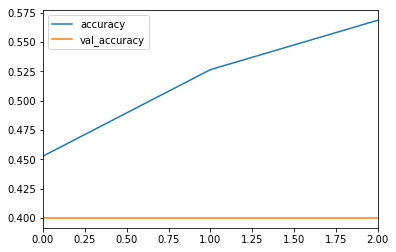

In [24]:
# Plot training and testing curves

import pandas as pd

df = pd.DataFrame(history.history)
df.plot(y=['accuracy', 'val_accuracy'])

In [25]:
# Inspect the checkpoint directory



In [27]:
# Create a new model with the saved weights



#### Clear directory

In [28]:
! rm -r model_checkpoints_5000 model_checkpoints_best

rm: cannot remove 'model_checkpoints_5000': No such file or directory
rm: cannot remove 'model_checkpoints_best': No such file or directory


***
<a id="coding_tutorial_3"></a>
## Saving the entire model

#### Create checkpoint that saves whole model, not just weights

In [29]:
from tensorflow.keras.callbacks import ModelCheckpoint

In [30]:
# Create Tensorflow checkpoint object

checkpoint = ModelCheckpoint('my_model', save_weights_only=False, frequency='epoch', verbose=1)


In [31]:
# Create and fit model with checkpoint

model = get_new_model()
model.fit(x_train, y_train, epochs=3, batch_size=16, callbacks=[checkpoint])

Train on 100 samples
Epoch 1/3
 96/100 [===========================>..] - ETA: 0s - loss: 2.2962 - accuracy: 0.1146
Epoch 00001: saving model to my_model
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: my_model/assets
100/100 [==============================] - 3s 29ms/sample - loss: 2.2958 - accuracy: 0.1200
Epoch 2/3
 96/100 [===========================>..] - ETA: 0s - loss: 2.2706 - accuracy: 0.0938
Epoch 00002: saving model to my_model
INFO:tensorflow:Assets written to: my_model/assets
100/100 [==============================] - 2s 20ms/sample - loss: 2.2682 - accuracy: 0.1000
Epoch 3/3
 80/100 [=======================>......] - ETA: 0s - loss: 2.2398 - accuracy: 0.1250
Epoch 00003: saving model to my_model
INFO:tensorflow:Assets written to: my_model/assets
100/100 [==============================] - 2s 16ms/sample - loss: 2.2556 - accuracy: 0.1300


#### Inspect what the checkpoint has created

In [32]:
# Have a look at what the checkpoint creates

! ls -lh my_model

total 128K
drwxr-xr-x 2 jovyan users 6.0K Apr  5 19:36 assets
-rw-r--r-- 1 jovyan users 119K Apr  6 05:27 saved_model.pb
drwxr-xr-x 2 jovyan users 6.0K Apr  6 05:27 variables


In [33]:
# Enter variables directory



In [34]:
# Get the model's test accuracy
get_test_accuracy(model, x_test, y_test)


accuracy: 0.100


#### Create new model from scratch

In [35]:
# Delete model

del model


In [36]:
from tensorflow.keras.models import load_model

In [37]:
# Reload model from scratch

model = load_model('my_model')

#### Use the .h5 format to save model

In [38]:
# Save the model in .h5 format
model.save('keras_model.')


INFO:tensorflow:Assets written to: keras_model./assets


In [39]:
# Inspect .h5 file



In [40]:
# Delete model



In [41]:
# Reload model from scratch



#### Clear directory

In [42]:
! rm -r model_checkpoints
! rm my_model.h5

rm: cannot remove 'model_checkpoints': No such file or directory
rm: cannot remove 'my_model.h5': No such file or directory


***
<a id="coding_tutorial_4"></a>
## Loading pre-trained Keras models

#### Import and build Keras ResNet50 model

Today we'll be using the ResNet50 model designed by a team at Microsoft Research, available through Keras applications. Please see the description on the [Keras applications page](https://keras.io/applications/#resnet) for details. If you continue using it, please cite it properly! The paper it comes from is:

Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun. "Deep Residual Learning for Image Recognition", 2015.

This model takes a long time to download on the Coursera platform, so it is pre-downloaded in your workspace and saved in Keras HDF5 format. If you want to import it on your personal machine, use the following code:

```python
from tensorflow.keras.applications import ResNet50
model = ResNet50(weights='imagenet')
```

In this coding tutorial, you will instead load the model directly from disk.

In [44]:
from tensorflow.keras.models import load_model

In [46]:
# Build Keras ResNet50 model
from tensorflow.keras.applications import ResNet50
model = ResNet50(weights='imagenet')

model = load_model('models/Keras_ResNet50.h5')


Exception: URL fetch failure on https://github.com/keras-team/keras-applications/releases/download/resnet/resnet50_weights_tf_dim_ordering_tf_kernels.h5: None -- Tunnel connection failed: 403 Forbidden

#### Import and preprocess 3 sample images

In [ ]:
# Import 3 sample ImageNet images

from tensorflow.keras.preprocessing.image import load_img

lemon_img = load_img('data/lemon.jpg', target_size=(224, 224))
viaduct_img = load_img('data/viaduct.jpg', target_size=(224, 224))
water_tower_img = load_img('data/water_tower.jpg', target_size=(224, 224))

#### Use ResNet50 model to classify images

In [ ]:
# Useful function: presents top 5 predictions and probabilities

from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np
import pandas as pd

def get_top_5_predictions(img):
    x = img_to_array(img)[np.newaxis, ...]
    x = preprocess_input(x)
    preds = decode_predictions(model.predict(x), top=5)
    top_preds = pd.DataFrame(columns=['prediction', 'probability'],
                             index=np.arange(5)+1)
    for i in range(5):
        top_preds.loc[i+1, 'prediction'] = preds[0][i][1]
        top_preds.loc[i+1, 'probability'] = preds[0][i][2] 
    return top_preds

##### Image 1: lemon

In [ ]:
# Display image



In [ ]:
# Display top 5 predictions



##### Image 2: viaduct

In [ ]:
# Display image



In [ ]:
# Display top 5 predictions



##### Image 3: water tower

In [ ]:
# Display image



In [ ]:
# Display top 5 predictions



***
<a id="coding_tutorial_5"></a>
## Tensorflow Hub modules

#### Import and build Tensorflow Hub MobileNet v1 model

Today we'll be using Google's MobileNet v1 model, available on Tensorflow Hub. Please see the description on the [Tensorflow Hub page](https://tfhub.dev/google/imagenet/mobilenet_v1_050_160/classification/4) for details on it's architecture, how it's trained, and the reference. If you continue using it, please cite it properly! The paper it comes from is:

Andrew G. Howard, Menglong Zhu, Bo Chen, Dmitry Kalenichenko, Weijun Wang, Tobias Weyand, Marco Andreetto, Hartwig Adam: "MobileNets: Efficient Convolutional Neural Networks for Mobile Vision Applications", 2017.

This model takes a long time to download on the Coursera platform, so it is pre-downloaded in your workspace and saved in Tensorflow SavedModel format. If you want to import it on your personal machine, use the following code:

```python
module_url = "https://tfhub.dev/google/imagenet/mobilenet_v1_050_160/classification/4"
model = Sequential([hub.KerasLayer(module_url)])
model.build(input_shape=[None, 160, 160, 3])
```

In this coding tutorial, you will instead load the model directly from disk.

In [47]:
import tensorflow_hub as hub
from tensorflow.keras.models import load_model

In [48]:
# Build Google's Mobilenet v1 model
module_url = "https://tfhub.dev/google/imagenet/mobilenet_v1_050_160/classification/4"
model = Sequential([hub.KerasLayer(module_url)])


URLError: <urlopen error Tunnel connection failed: 403 Forbidden>

#### Use MobileNet model to classify images

In [ ]:
# Import and preprocess 3 sample ImageNet images

from tensorflow.keras.preprocessing.image import load_img

lemon_img = load_img("data/lemon.jpg", target_size=(160, 160))
viaduct_img = load_img("data/viaduct.jpg", target_size=(160, 160))
water_tower_img = load_img("data/water_tower.jpg", target_size=(160, 160))

In [ ]:
# Read in categories text file

with open('data/imagenet_categories.txt') as txt_file:
    categories = txt_file.read().splitlines()

In [ ]:
# Useful function: presents top 5 predictions

import pandas as pd

def get_top_5_predictions(img):
    x = img_to_array(img)[np.newaxis, ...] / 255.0
    preds = model.predict(x)
    top_preds = pd.DataFrame(columns=['prediction'],
                             index=np.arange(5)+1)
    sorted_index = np.argsort(-preds[0])
    for i in range(5):
        ith_pred = categories[sorted_index[i]]
        top_preds.loc[i+1, 'prediction'] = ith_pred
            
    return top_preds

##### Image 1: lemon

##### Image 2: viaduct

##### Image 3: water tower